## Library Imports

In [1]:
import keras
import numpy as np

import time

import os

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.layers as tfl

# import misc

import pandas as pd

import datetime

import glob

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Conv1D, MaxPooling1D, Flatten, \
                                    Masking, LSTM, Softmax, Multiply, Layer, Concatenate, Lambda, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras.utils import np_utils
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

import tensorly as tl
from tensorly.decomposition import tucker

2025-02-24 23:52:09.597959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740469929.618681   41154 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740469929.624701   41154 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 23:52:09.647467: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Import Data

In [2]:
# Mapping for string labels to integers
label_mapping = {"CN": 0, "MCI": 1, "Dementia": 2}

max_seq_length = 6

manifest = pd.read_csv("/home/mason/TFN_AD/AD_Patient_Manifest.csv")

In [3]:
# Load all data into memory. Not elegant, but works.
def load_all_data(manifest, target_size=(224, 224), demographic_columns=None, time_series_columns=None, label_mapping=None):
    image_data = []
    demographics_data = []
    time_series_data = []
    labels = []
    label_mapping = label_mapping or {}

    for _, row in manifest.iterrows():
        patient_path = row["path"]
        patient_df = pd.read_pickle(patient_path)

        # Load image data
        image_paths = [patient_df['image_path'].iloc[0]]
        for path in image_paths:
            img = load_img(path, target_size=target_size)
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            image_data.append(img_array)

        # Process demographics data
        if demographic_columns is None:
            raise ValueError("Please specify the demographics columns.")
        
        # Get first row of demographic data (since it doesn't change over time)
        demographics = patient_df[demographic_columns].iloc[0]
        demographics = demographics.values.astype(np.float32)  # Convert to NumPy array
        demographics_data.append(demographics)

        # Process time series data
        if time_series_columns is None:
            raise ValueError("Please specify the time series columns.")
        
        # Extract the relevant time series columns
        time_series = patient_df[time_series_columns].values  # Extract as NumPy array

        # Truncate or pad to max_seq_length
        if len(time_series) > max_seq_length:
            time_series = time_series[:max_seq_length, :]
        elif len(time_series) < max_seq_length:
            padding = np.zeros((max_seq_length - len(time_series), len(time_series_columns)))
            time_series = np.vstack([time_series, padding])
        time_series_data.append(time_series)

        # Load labels
        label_str = patient_df['DX'].iloc[0]
        label_int = label_mapping[label_str]
        labels.append(label_int)

    # Convert to numpy arrays
    image_data = np.array(image_data, dtype=np.float32)
    demographics_data = np.array(demographics_data, dtype=np.float32)
    time_series_data = np.array(time_series_data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    return image_data, demographics_data, time_series_data, labels

In [4]:
# Demographic variables to extract
demographic_columns = ['AGE', 'PTEDUCAT', 'PTGENDER_encoded', 
                        'PTETHCAT_encoded', 'PTRACCAT_encoded', 'PTMARRY_encoded']
# Time series variables to extract
time_series_columns = ['Years_bl', 'ADAS11', 'ADAS13', 'ADASQ4']

# Load all data into memory
image_data, demographics_data, time_series_data, labels = load_all_data(manifest, target_size=(224, 224), demographic_columns=demographic_columns, 
                                                      time_series_columns=time_series_columns, label_mapping=label_mapping)

# Split the data
test_size = 0.2  # 20% of the data for testing

(image_train, image_test,
 demographics_train, demographics_test,
 time_train, time_test,
 labels_train, labels_test) = train_test_split(
    image_data, demographics_data, time_series_data, labels, test_size=test_size, random_state=42, stratify=labels
)

In [5]:
batch_size = 64

# Create training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(((image_train, demographics_train, time_train), labels_train))
# train_dataset = train_dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create testing (validation) dataset
test_dataset = tf.data.Dataset.from_tensor_slices(((image_test, demographics_test, time_test), labels_test))
# test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

W0000 00:00:1740469936.865273   41154 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Visual Models

### Map Image Data

In [6]:
def extract_images_labels(data, label):
    images = data[0]  # Extract only images
    return images, label

# Modify dataset to keep only images and labels
image_train_dataset = train_dataset.map(extract_images_labels)
image_test_dataset = test_dataset.map(extract_images_labels)

# Preprocess images for VGG-16
def preprocess(image, label):
    # image = tf.squeeze(image, axis=0)  # Remove extra batch dimension if it exists
    image = tf.image.resize(image, (224, 224))  # Resize to VGG-16 input size
    image = preprocess_input(image)  # Normalize with VGG-16 preprocessing
    return image, label

image_train_dataset = image_train_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
image_test_dataset = image_test_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

### VGG-16

In [7]:
# === 2. Load Pretrained VGG-16 Model ===
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

# === 3. Add Classification Head ===
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # Adjust num_classes for your dataset

model = Model(inputs=base_model.input, outputs=output)

# === 4. Compile & Train Model ===
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [8]:
# Early stopping to prevent redundant training.
vgg_early_stopping = EarlyStopping(monitor='accuracy', patience=20, restore_best_weights=True)

In [ ]:
# Train model
vgg_history = model.fit(
    image_train_dataset, 
    validation_data=image_test_dataset, 
    epochs=60, 
    callbacks=[vgg_early_stopping])

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 919ms/step - accuracy: 0.3231 - loss: 4.7881 - val_accuracy: 0.4026 - val_loss: 1.5676
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 893ms/step - accuracy: 0.3368 - loss: 4.6713 - val_accuracy: 0.4416 - val_loss: 1.5536
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 882ms/step - accuracy: 0.3251 - loss: 5.1790 - val_accuracy: 0.4156 - val_loss: 1.4271
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 877ms/step - accuracy: 0.3550 - loss: 4.4623 - val_accuracy: 0.4416 - val_loss: 1.5372
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 872ms/step - accuracy: 0.3446 - loss: 4.5890 - val_accuracy: 0.4416 - val_loss: 1.5054
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 879ms/step - accuracy: 0.2967 - loss: 4.4055 - val_accuracy: 0.4156 - val_loss: 1.4166
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 889ms/step - accuracy: 0.3893 - loss: 3.4891 - val_accuracy: 0.4156 - val_loss: 1.4232
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 876ms/step - accuracy: 0.3314 - loss: 3.8800 - val_accuracy: 0

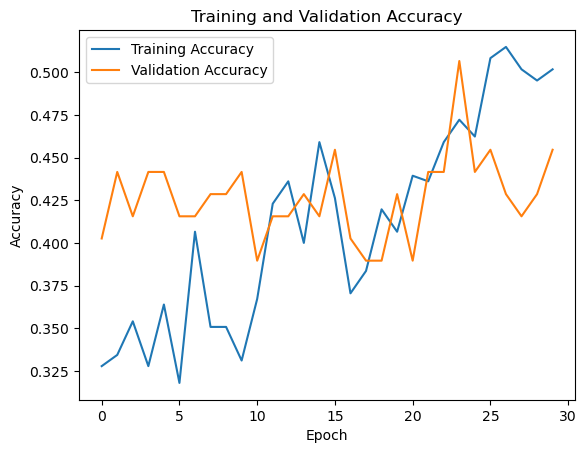

In [10]:
# Get training and validation accuracy and loss from the history object
train_acc = vgg_history.history['accuracy']
val_acc = vgg_history.history['val_accuracy']
train_loss = vgg_history.history['loss']
val_loss = vgg_history.history['val_loss']

# Plot training and validation accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

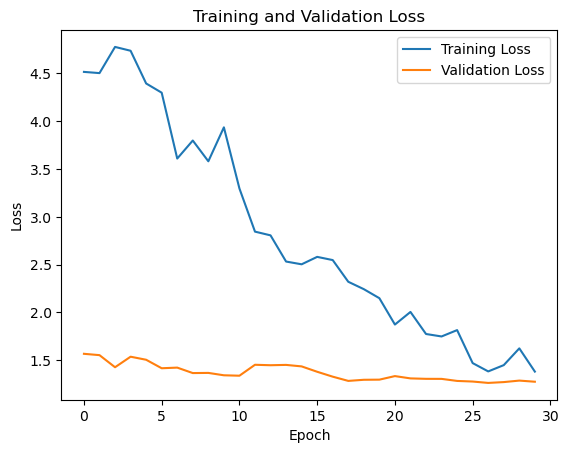

In [11]:
# Plot training and validation loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [12]:
# Get the final accuracy and loss for the last epoch
final_train_acc = vgg_history.history['accuracy'][-1]
final_val_acc = vgg_history.history['val_accuracy'][-1]
final_train_loss = vgg_history.history['loss'][-1]
final_val_loss = vgg_history.history['val_loss'][-1]

# Print the final accuracy and loss
print("Final Training Accuracy:", final_train_acc)
print("Final Validation Accuracy:", final_val_acc)
print("Final Training Loss:", final_train_loss)
print("Final Validation Loss:", final_val_loss)

Final Training Accuracy: 0.5016393661499023
Final Validation Accuracy: 0.4545454680919647
Final Training Loss: 1.3815851211547852
Final Validation Loss: 1.2755839824676514


## Demographic Models

### CART

In [7]:
# === 1. Extract Demographic Data and Labels ===
def extract_demographics_labels(data, label):
    demographics = data[1]  # Extract only demographics_train
    return demographics, label

demographic_dataset = tf.data.Dataset.from_tensor_slices(((image_train, demographics_train, time_train), labels_train))
demographic_dataset = demographic_dataset.map(extract_demographics_labels)

# Convert TensorFlow dataset to NumPy arrays
demographics_list = []
labels_list = []

for demographics, label in demographic_dataset.as_numpy_iterator():
    demographics_list.append(demographics)
    labels_list.append(label)

X = np.array(demographics_list)  # Features (demographics)
y = np.array(labels_list)  # Labels

# === 2. Split Data into Train & Test Sets ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 3. Train a CART Decision Tree Classifier ===
clf = DecisionTreeClassifier(criterion="gini", max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# === 4. Make Predictions & Evaluate ===
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Decision Tree Accuracy: {accuracy:.6f}")

Decision Tree Accuracy: 0.524590


2025-02-24 23:52:25.612600: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
y_train_pred = clf.predict(X_train)
accuracy = accuracy_score(y_train, y_train_pred)

print(f"Decision Tree Accuracy: {accuracy:.6f}")

Decision Tree Accuracy: 0.602459


### Random Forest

In [8]:
# May need greed search to find the best parameters (and hyperparameters)

# Train Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=10, random_state=42)
rf_clf.fit(X_train, y_train)

# Make Preds and find performance.
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Random Forest Accuracy: {accuracy:.6f}")

Random Forest Accuracy: 0.491803


In [9]:
y_train_pred = rf_clf.predict(X_train)
accuracy = accuracy_score(y_train, y_train_pred)

print(f"Random Forest Accuracy: {accuracy:.6f}")

Random Forest Accuracy: 0.922131


In [11]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.55      0.55      0.55        22
           1       0.50      0.48      0.49        25
           2       0.40      0.43      0.41        14

    accuracy                           0.49        61
   macro avg       0.48      0.48      0.48        61
weighted avg       0.49      0.49      0.49        61



In [12]:
params={'n_estimators':[150, 125, 100, 20, 50, 25, 32],  
        'max_depth':[5, 6, 10, 11, 12, 15, 20], 
        'random_state':[11, 66, 232, 23, 42, 88, 101], 
        } 

grid_search = GridSearchCV(rf_clf,
                           param_grid=params)

grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=5, n_estimators=25, random_state=232)


In [13]:
# Train Random Forest
adjusted_rf = RandomForestClassifier(n_estimators=25, criterion="gini", max_depth=5, random_state=232)
adjusted_rf.fit(X_train, y_train)

# Make Preds and find performance.
y_pred = adjusted_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Random Forest Accuracy: {accuracy:.6f}")

Random Forest Accuracy: 0.508197


In [14]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.41      0.60      0.49        15
           1       0.88      0.48      0.62        44
           2       0.07      0.50      0.12         2

    accuracy                           0.51        61
   macro avg       0.45      0.53      0.41        61
weighted avg       0.73      0.51      0.57        61



In [15]:
y_train_pred = adjusted_rf.predict(X_train)
accuracy = accuracy_score(y_train, y_train_pred)

print(f"Random Forest Accuracy: {accuracy:.6f}")

Random Forest Accuracy: 0.627049


## Time-Series Models

### LSTM

In [6]:
# === 1. Extract Time-Series Data and Labels ===
def extract_time_series_labels(data, label):
    time_series = data[2]  # Extract only time_train
    return time_series, label

# Create a dataset with only time-series and labels
time_dataset = tf.data.Dataset.from_tensor_slices(((image_train, demographics_train, time_train), labels_train))
time_dataset = time_dataset.map(extract_time_series_labels)

# Convert dataset to NumPy arrays
time_series_list = []
labels_list = []

for time_series, label in time_dataset.as_numpy_iterator():
    time_series_list.append(time_series)
    labels_list.append(label)

X = np.array(time_series_list)  # Features (time-series)
y = np.array(labels_list)  # Labels

2025-02-19 00:45:03.622827: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
max_seq_length = 6

def build_time_embedder():
    # Input layer for time series data (4 input variables)
    time_series_input = Input(shape=(max_seq_length, 4), name="time_series_input")
    masked_input = Masking(mask_value=0.0)(time_series_input)

    # Use the last hidden state
    x = LSTM(32, return_sequences=False)(masked_input)

    x = Dropout(0.5)(x)

    # Dense layer to create time series output
    time_base_features = Dense(16, activation="relu")(x)
    
    # Define the model
    time_model = Model(inputs=time_series_input, outputs=time_base_features, name="TimeSeriesEmbedder")
    return time_model

In [8]:
# === 2. Reshape for LSTM Input ===
# Ensure shape (samples, time_steps, features)
# X = X.reshape((X.shape[0], X.shape[1], 1))  # Add feature dimension if needed

# Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

time_embedder = build_time_embedder()

time_features = time_embedder.output

lstm_hidden = Dense(64, activation='relu')(time_features)
# x = Dropout(0.5)(x)
lstm_pred = Dense(3, activation='softmax', name="final_output")(lstm_hidden)

# Define the combined model
lstm_model = Model(inputs=time_embedder.input, outputs=lstm_pred, name="lstm_model")

# === 4. Compile & Train the Model ===
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent redundant training.
lstm_early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)

# Train the LSTM model
lstm_history = lstm_model.fit(X_train, 
                              y_train, 
                              epochs=90, 
                              batch_size=32, 
                              validation_data=(X_test, y_test),
                              callbacks=[lstm_early_stopping])

Epoch 1/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3818 - loss: 1.0836 - val_accuracy: 0.3934 - val_loss: 1.0496
Epoch 2/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4130 - loss: 1.0525 - val_accuracy: 0.3934 - val_loss: 1.0265
Epoch 3/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3948 - loss: 1.0235 - val_accuracy: 0.4754 - val_loss: 0.9932
Epoch 4/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4771 - loss: 0.9800 - val_accuracy: 0.5246 - val_loss: 0.9472
Epoch 5/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5984 - loss: 0.9455 - val_accuracy: 0.7049 - val_loss: 0.8885
Epoch 6/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6306 - loss: 0.9048 - val_accuracy: 0.7705 - val_loss: 0.8201
Epoch 7/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6086 - loss: 0.8456 - val_accuracy: 0.7705 - val_loss: 0.7588
Epoch 8/90
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7208 - loss: 0.7790 - val_accuracy: 0.7377 - val_loss: 0.6973
Epoch

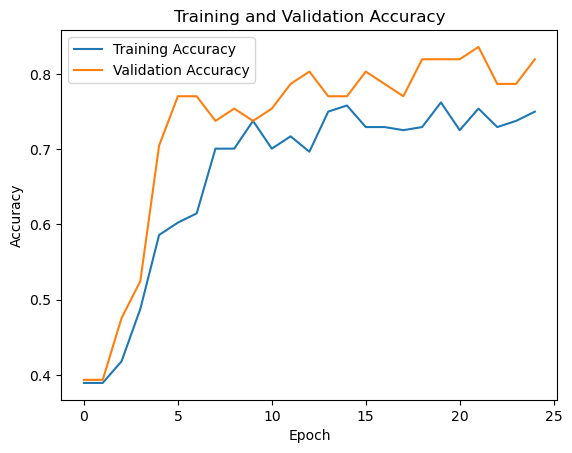

In [9]:
# Get training and validation accuracy and loss from the history object
lstm_train_acc = lstm_history.history['accuracy']
lstm_val_acc = lstm_history.history['val_accuracy']
lstm_train_loss = lstm_history.history['loss']
lstm_val_loss = lstm_history.history['val_loss']

# Plot training and validation accuracy
plt.figure()
plt.plot(lstm_train_acc, label='Training Accuracy')
plt.plot(lstm_val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

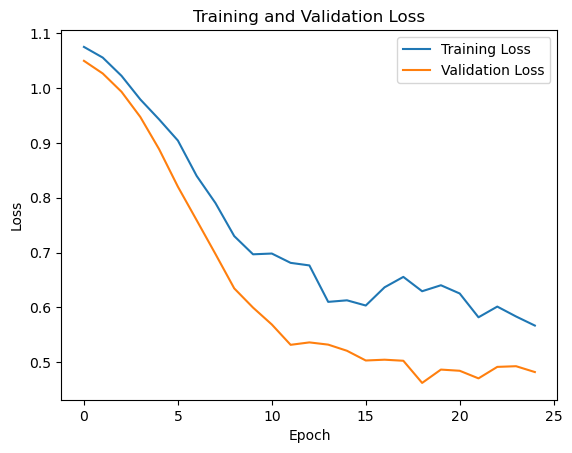

In [10]:
# Plot training and validation loss
plt.figure()
plt.plot(lstm_train_loss, label='Training Loss')
plt.plot(lstm_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [11]:
# Get the final accuracy and loss for the last epoch
lstm_final_train_acc = lstm_history.history['accuracy'][-1]
lstm_final_val_acc = lstm_history.history['val_accuracy'][-1]
lstm_final_train_loss = lstm_history.history['loss'][-1]
lstm_final_val_loss = lstm_history.history['val_loss'][-1]

# Print the final accuracy and loss
print("Final Training Accuracy:", lstm_final_train_acc)
print("Final Validation Accuracy:", lstm_final_val_acc)
print("Final Training Loss:", lstm_final_train_loss)
print("Final Validation Loss:", lstm_final_val_loss)

Final Training Accuracy: 0.75
Final Validation Accuracy: 0.8196721076965332
Final Training Loss: 0.5667610764503479
Final Validation Loss: 0.4819994866847992


## Joint Models

### VGG-LSTM

In [17]:
# multimodal_train_dataset = tf.data.Dataset.from_tensor_slices(((image_train, time_train), labels_train))
# multimodal_train_dataset = train_dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# multimodal_test_dataset = tf.data.Dataset.from_tensor_slices(((image_test, time_test), labels_test))
# multimodal_test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

def extract_images_time_labels(data, label):
    images = data[0]  # Extract only images
    time = data[2]
    return (images, time), label

# Modify dataset to keep only images and labels
multimodal_train_dataset = train_dataset.map(extract_images_time_labels)
multimodal_test_dataset = test_dataset.map(extract_images_time_labels)

# Preprocess images for VGG-16
def preprocess(data, label):
    data[0] = tf.image.resize(data[0], (224, 224))  # Resize to VGG-16 input size
    data[0] = preprocess_input(data[0])  # Normalize with VGG-16 preprocessing
    return (data[0], data[1]), label

multimodal_train_dataset = multimodal_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
multimodal_test_dataset = multimodal_test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
# === 1. Define the VGG-16 Model for Image Features ===
def build_vgg_branch():
    vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    vgg_base.trainable = False  # Freeze pretrained weights

    x = vgg_base.output
    x = GlobalAveragePooling2D()(x)  # Convert to feature vector
    x = Dense(256, activation="relu")(x)  # Reduce dimensionality
    x = Dropout(0.5)(x)
    x = Dense(64, activation="relu")(x)
    
    return Model(inputs=vgg_base.input, outputs=x, name="VGG_Branch")

# Reuse LSTM branch from LSTM section!!!

In [19]:
# === 3. Create the Multi-Modal Fusion Model ===
def build_multi_modal_model(num_classes):
    # Create branches
    vgg_branch = build_vgg_branch()
    lstm_branch = build_time_embedder()

    # Concatenate VGG and LSTM outputs
    combined = Concatenate()([vgg_branch.output, lstm_branch.output])
    
    # Fully connected classifier
    x = Dense(128, activation="relu")(combined)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="softmax")(x)  # Adjust num_classes

    # Define full model
    model = Model(inputs=[vgg_branch.input, lstm_branch.input], outputs=output, name="VGG_LSTM_Fusion")

    return model

# === 4. Compile the Model ===
num_classes = 3  # Number of output classes

multi_modal_model = build_multi_modal_model(num_classes)
multi_modal_model.compile(optimizer=Adam(learning_rate=1e-4),
                          loss="sparse_categorical_crossentropy",
                          metrics=["accuracy"])

In [20]:
# Early stopping to prevent redundant training.
multimodal_early_stopping = EarlyStopping(monitor='accuracy', patience=20, restore_best_weights=True)

# === 5. Train the Model ===
multimodal_history = multi_modal_model.fit(multimodal_train_dataset, 
                      validation_data=multimodal_test_dataset, 
                      epochs=90, 
                      callbacks=[multimodal_early_stopping])

Epoch 1/90


/home/mason/.conda/envs/LOSresearch/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_56', 'time_series_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 961ms/step - accuracy: 0.3263 - loss: 3.0002 - val_accuracy: 0.3506 - val_loss: 1.1518
Epoch 2/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 882ms/step - accuracy: 0.3411 - loss: 2.7818 - val_accuracy: 0.4156 - val_loss: 1.1551
Epoch 3/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 882ms/step - accuracy: 0.3013 - loss: 2.4226 - val_accuracy: 0.4156 - val_loss: 1.1714
Epoch 4/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 882ms/step - accuracy: 0.3652 - loss: 2.0195 - val_accuracy: 0.4026 - val_loss: 1.1733
Epoch 5/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 879ms/step - accuracy: 0.3538 - loss: 2.2299 - val_accuracy: 0.4026 - val_loss: 1.1369
Epoch 6/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 878ms/step - accuracy: 0.3872 - loss: 1.8419 - val_accuracy: 0.3766 - val_loss: 1.1210
Epoch 7/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 875ms/step - accuracy: 0.3490 - loss: 2.0119 - val_accuracy: 0.3896 - val_loss: 1.1193
Epoch 8/90
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 878ms/step - accuracy: 0.3929 - loss: 1.7836 - val_accuracy: 0.3506 - val

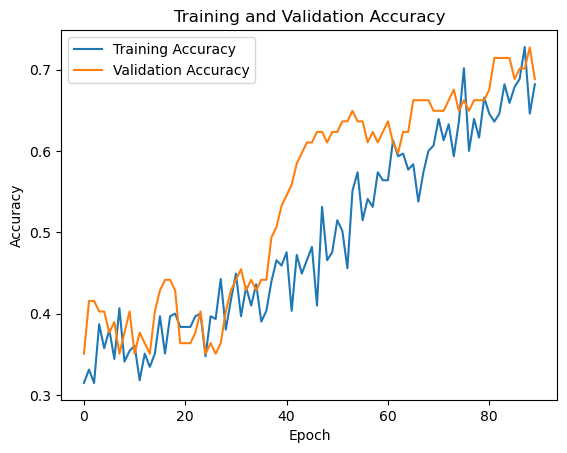

In [21]:
# Get training and validation accuracy and loss from the history object
multimodal_train_acc = multimodal_history.history['accuracy']
multimodal_val_acc = multimodal_history.history['val_accuracy']
multimodal_train_loss = multimodal_history.history['loss']
multimodal_val_loss = multimodal_history.history['val_loss']

# Plot training and validation accuracy
plt.figure()
plt.plot(multimodal_train_acc, label='Training Accuracy')
plt.plot(multimodal_val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

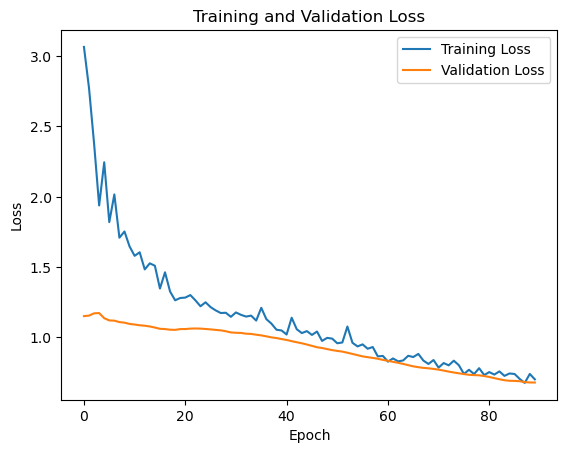

In [22]:
# Plot training and validation loss
plt.figure()
plt.plot(multimodal_train_loss, label='Training Loss')
plt.plot(multimodal_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [23]:
# Get the final accuracy and loss for the last epoch
multimodal_final_train_acc = multimodal_history.history['accuracy'][-1]
multimodal_final_val_acc = multimodal_history.history['val_accuracy'][-1]
multimodal_final_train_loss = multimodal_history.history['loss'][-1]
multimodal_final_val_loss = multimodal_history.history['val_loss'][-1]

# Print the final accuracy and loss
print("Final Training Accuracy:", multimodal_final_train_acc)
print("Final Validation Accuracy:", multimodal_final_val_acc)
print("Final Training Loss:", multimodal_final_train_loss)
print("Final Validation Loss:", multimodal_final_val_loss)

Final Training Accuracy: 0.6819671988487244
Final Validation Accuracy: 0.6883116960525513
Final Training Loss: 0.702044665813446
Final Validation Loss: 0.6794608235359192
